## Import Library and Data Process

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path


Bad key "text.kerning_factor" on line 4 in
/Users/weirongtian/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import pypfopt
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import EfficientFrontier
from pypfopt import CLA, plotting
from pypfopt import objective_functions

In [3]:
#import data 
stock_path = Path('../Resources/stock_prices.csv')
stock_prices = pd.read_csv(stock_path,parse_dates=True,index_col='Date',infer_datetime_format=True)

In [4]:
crypto_path = Path('../Resources/crypto_prices.csv')
crypto_prices = pd.read_csv(crypto_path,parse_dates=True,index_col='Date',infer_datetime_format=True)

In [5]:
prices=stock_prices.join(crypto_prices)

In [6]:
prices=prices.drop(columns="SPY")

## Calculating the covariance matrix

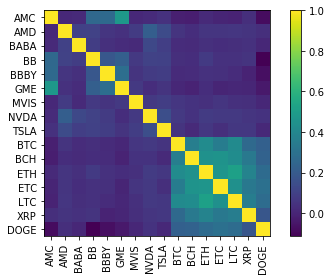

In [7]:
#Calculating the covariance matrix 
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
plotting.plot_covariance(S, plot_correlation=True);

## Return estimation

In [8]:
mu = expected_returns.mean_historical_return(prices)
mu

AMC    -0.069066
AMD     0.580927
BABA    0.093133
BB     -0.020811
BBBY   -0.030631
GME     0.809258
MVIS    0.628576
NVDA    0.400135
TSLA    0.792867
BTC     1.040406
BCH     0.225117
ETH     0.935497
ETC     0.534400
LTC     0.522273
XRP     0.644360
DOGE    3.154055
dtype: float64

## Max Sharpe Ratio 

In [9]:
#Max Sharpe
ef = EfficientFrontier(mu, S) 
ef.max_sharpe()

OrderedDict([('AMC', 0.0),
             ('AMD', 0.1562462723391428),
             ('BABA', 0.0),
             ('BB', 0.0),
             ('BBBY', 0.0),
             ('GME', 0.0969073792650799),
             ('MVIS', 0.0458846366323714),
             ('NVDA', 0.0549319823248896),
             ('TSLA', 0.242574350678294),
             ('BTC', 0.2004942397369767),
             ('BCH', 0.0),
             ('ETH', 0.0236124143357805),
             ('ETC', 0.0),
             ('LTC', 0.0),
             ('XRP', 0.0),
             ('DOGE', 0.1793487246874653)])

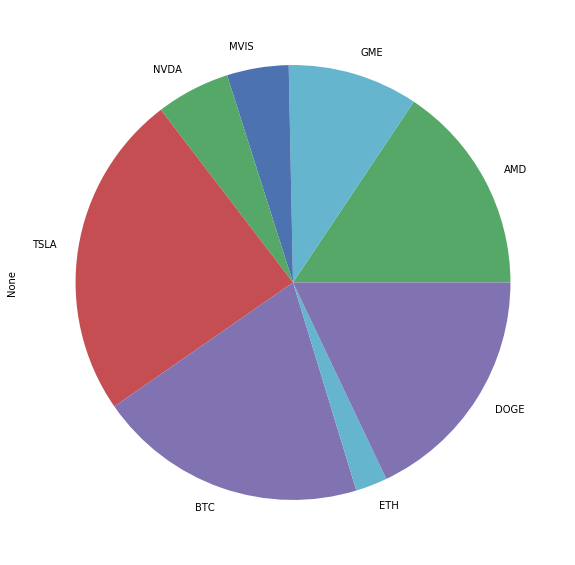

In [10]:
#draw pie chart
weights_maxsharpe = ef.clean_weights()
pd.Series(weights_maxsharpe).plot.pie(figsize=(10,10));

In [11]:
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt((w.T * (S @ w.T)).sum(axis=0))
sharpes = rets / stds

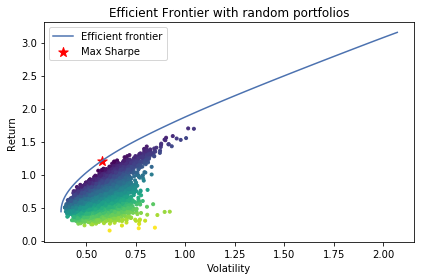

In [12]:
# Draw Efficient frontier
ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find and plot the tangency portfolio
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Plot random portfolios
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()

### Maximise Return Given Risk

In [13]:
target_volatility=0.6
ef = EfficientFrontier(mu, S)
ef.efficient_risk(target_volatility)
ef.add_objective(objective_functions.L2_reg, gamma=0.1) 
weights_givenrisk = ef.clean_weights()
weights_givenrisk

OrderedDict([('AMC', 0.0),
             ('AMD', 0.15148),
             ('BABA', 0.0),
             ('BB', 0.0),
             ('BBBY', 0.0),
             ('GME', 0.09905),
             ('MVIS', 0.04472),
             ('NVDA', 0.0382),
             ('TSLA', 0.24739),
             ('BTC', 0.2053),
             ('BCH', 0.0),
             ('ETH', 0.0193),
             ('ETC', 0.0),
             ('LTC', 0.0),
             ('XRP', 0.0),
             ('DOGE', 0.19456)])

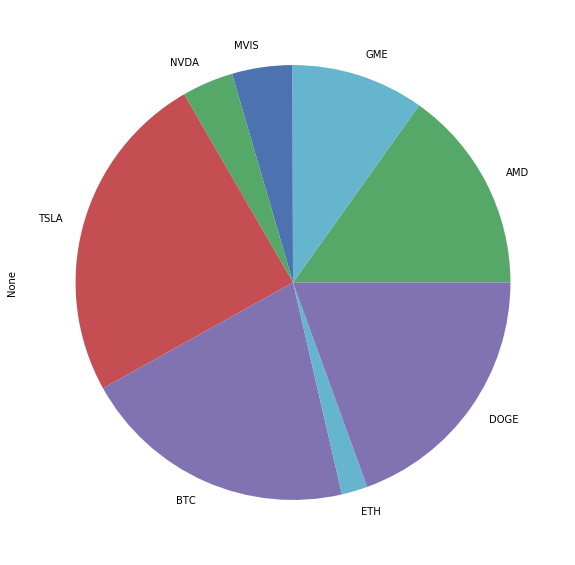

In [14]:
pd.Series(weights_givenrisk).plot.pie(figsize=(10, 10));

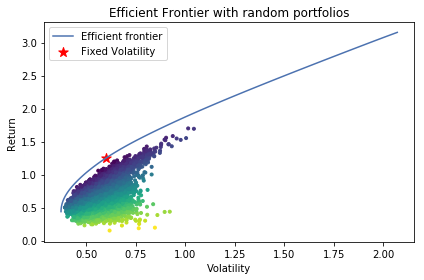

In [15]:
ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find and plot the tangency portfolio
ef.efficient_risk(target_volatility=0.6)
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Fixed Volatility")

# Plot random portfolios
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()

## Minimize Risk given Return

In [16]:
target_return=0.7
ef = EfficientFrontier(mu, S, weight_bounds=(0,1))
ef.add_objective(objective_functions.L2_reg, gamma=0.1) 
ef.efficient_return(target_return)
weights_givenreturn = ef.clean_weights()
weights_givenreturn

OrderedDict([('AMC', 0.0),
             ('AMD', 0.13344),
             ('BABA', 0.14223),
             ('BB', 0.06966),
             ('BBBY', 0.05713),
             ('GME', 0.04983),
             ('MVIS', 0.0446),
             ('NVDA', 0.11459),
             ('TSLA', 0.14701),
             ('BTC', 0.12512),
             ('BCH', 0.0),
             ('ETH', 0.03694),
             ('ETC', 0.0),
             ('LTC', 0.0),
             ('XRP', 0.01342),
             ('DOGE', 0.06604)])

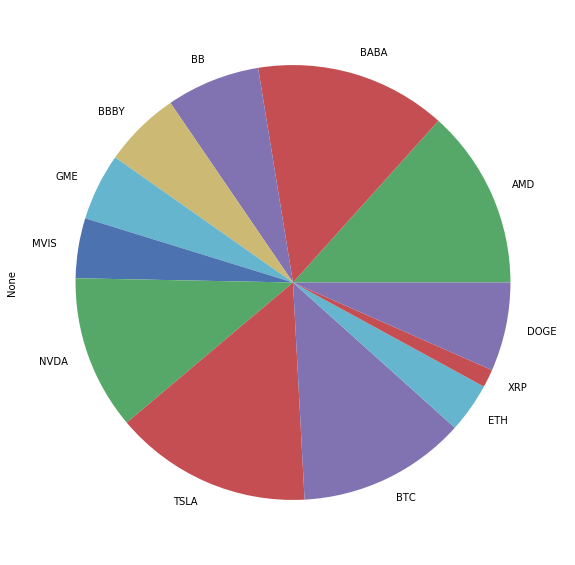

In [17]:
pd.Series(weights_givenreturn).plot.pie(figsize=(10, 10));

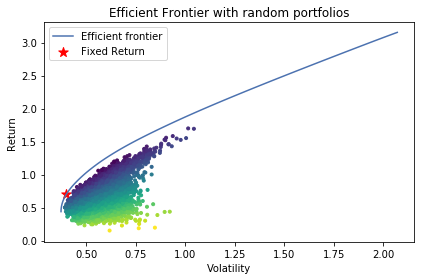

In [18]:
ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find and plot the tangency portfolio
ef.efficient_return(target_return)
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Fixed Return")

# Plot random portfolios
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()

## Monte Carlo Simulation

### import library and change portoflio data format

In [19]:
from MCForecastTools import MCSimulation
from collections import OrderedDict
import hvplot.pandas

In [20]:
portfolio_data=prices
tickers = prices.columns
column_names = [(x,"close") for x in tickers]
portfolio_data.columns = pd.MultiIndex.from_tuples(column_names)

### Max Sharpe Portfolio

In [21]:
weights_ms=[]
for key in weights_maxsharpe.keys():
    weights_ms.append(weights_maxsharpe[key])

In [22]:
maxsharpe_simulation_data = MCSimulation(
    portfolio_data = portfolio_data,
    weights = weights_ms,
    num_simulation = 100,
    num_trading_days = 252
)

In [23]:
maxsharpe_simulation=maxsharpe_simulation_data.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


In [24]:
maxsharpe_simulation.hvplot(title="100 Simulations of MaxSharpe Portfolio over next 252 Trading Days")

:NdOverlay   [Variable]
   :Curve   [index]   (value)

### Maximize Return Given Risk

In [25]:
weights_risk=[]
for key in weights_givenrisk.keys():
    weights_risk.append(weights_givenrisk[key])

In [26]:
givenrisk_simulation_data = MCSimulation(
    portfolio_data = portfolio_data,
    weights = weights_risk,
    num_simulation = 100,
    num_trading_days = 252
)

In [27]:
givenrisk_simulation=givenrisk_simulation_data.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


In [28]:
givenrisk_simulation.hvplot(title="100 Simulations of Givenrisk Portfolio over next 252 Trading Days")

:NdOverlay   [Variable]
   :Curve   [index]   (value)

### Minimize Risk Given Return

In [29]:
weights_return=[]
for key in weights_givenreturn.keys():
    weights_return.append(weights_givenreturn[key])

In [30]:
givenreturn_simulation_data = MCSimulation(
    portfolio_data = portfolio_data,
    weights = weights_return,
    num_simulation = 100,
    num_trading_days = 252
)

In [31]:
givenreturn_simulation=givenreturn_simulation_data.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


In [32]:
givenreturn_simulation.hvplot(title="100 Simulations of Given Return Portfolio over next 252 Trading Days")

:NdOverlay   [Variable]
   :Curve   [index]   (value)